# Motivation:
This notebook aims to add categorical variables to a simple feed forward neural net.

Findings:
- If you add loss.items() with reduction 'mean' (default) the loss of the last incomplete batch gets too much weight

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

import sys
root = Path().resolve().parents[0]

if str(root) not in sys.path:
    sys.path = [str(root)] + sys.path
    print(f"Path updated with: {root}.")

Path updated with: /Users/giovanniganzinotti/repos/pytorch-azure.


# DGP

In [2]:
ranseed = 16
np.random.seed(ranseed)

In [3]:
n = 116_067

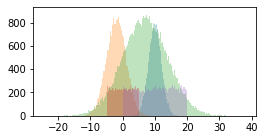

In [4]:
def get_normal_variable(size, mu, sigma):
    return sigma * np.random.randn(size) + mu

def get_uniform_variable(size, low, high):
    var_range = high - low
    return np.random.random(size=size) * var_range + low
    
    
num_var_1 = get_normal_variable(n, 10, 2)
num_var_2 = get_normal_variable(n, -2, 3)
num_var_3 = get_normal_variable(n, 7, 7)
num_var_4 = get_uniform_variable(n, -5, 5)
num_var_5 = get_uniform_variable(n, 0, 20)

fig, ax = plt.subplots(figsize=(4, 2))
for var in (num_var_1, num_var_2, num_var_3, num_var_4, num_var_5):
    ax = plt.hist(var, bins=500, alpha=0.3)
plt.show()

In [5]:
def return_categorical_variable_with_contribution(
    cardinality: int, size: int, choices: list = None
):  
    np.random.shuffle(choices)
    cat_var = np.random.choice(choices, n)
    
    contributions = np.random.randint(-30, 31, size=len(choices))
    contribution_dict = {
        val: contributions[ind]
        for ind, val in enumerate(choices)
    }
    contribution_var = np.vectorize(contribution_dict.get)(cat_var)
    print(f"contribution stats: {contribution_var.min()}, {contribution_var.mean()}, {contribution_var.max()}")
    return cat_var, contribution_var

low_cardinality = 5
low_cardinal_cat, low_cardinal_cat_contribution = return_categorical_variable_with_contribution(
    low_cardinality, n, choices=list(range(low_cardinality))
)
med_cardinality = 30
med_cardinal_cat, med_cardinal_cat_contribution = return_categorical_variable_with_contribution(
    med_cardinality, n, choices=list(range(med_cardinality))
)
high_cardinality = 200
high_cardinal_cat, high_cardinal_cat_contribution = return_categorical_variable_with_contribution(
    high_cardinality, n, choices=list(range(high_cardinality))
)

contribution stats: -28, -8.226059086562072, 7
contribution stats: -27, -1.9366572755391283, 26
contribution stats: -30, -0.7688490268551784, 30


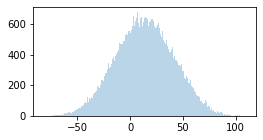

In [6]:
target = (
    num_var_1
    + num_var_2
    + num_var_3
    + num_var_4
    + num_var_5
    + low_cardinal_cat_contribution
    + med_cardinal_cat_contribution
    + high_cardinal_cat_contribution
)

fig, ax = plt.subplots(figsize=(4, 2))
ax = plt.hist(target, bins=500, alpha=0.3)
plt.show()

In [7]:
data = pd.DataFrame({
    "variable_1": med_cardinal_cat,
    "variable_2": num_var_2,
    "variable_3": num_var_5,
    "variable_4": low_cardinal_cat,
    "variable_5": num_var_1,
    "variable_6": high_cardinal_cat,
    "variable_7": num_var_4,
    "variable_8": num_var_3,
    "target": target,
})

data.head()

,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,target
0,15,-2.875093,16.238094,2,10.255897,14,-4.482168,21.193341,21.330071
1,5,1.958975,15.312452,3,6.943053,92,-4.813078,4.755547,0.156948
2,5,-4.892599,5.936707,1,8.811064,27,-4.837997,2.773702,-12.209124
3,25,2.850325,5.365250,0,10.132661,22,-4.462724,9.221969,-21.892519
4,14,-4.650473,9.099123,2,7.529010,136,-0.428547,-3.921329,36.627785


In [8]:
data.corr()

,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,target
variable_1,1.000000,-0.000915,0.005512,0.000030,-0.002374,-0.002609,0.006243,0.000082,-0.049406
variable_2,-0.000915,1.000000,-0.000673,-0.004100,0.002614,0.000791,-0.003282,-0.004176,0.107726
variable_3,0.005512,-0.000673,1.000000,0.006904,-0.000720,-0.000945,-0.003460,-0.003005,0.209862
variable_4,0.000030,-0.004100,0.006904,1.000000,0.002692,-0.004915,-0.000539,-0.000764,0.295452
variable_5,-0.002374,0.002614,-0.000720,0.002692,1.000000,0.000751,0.002413,0.003673,0.074277
variable_6,-0.002609,0.000791,-0.000945,-0.004915,0.000751,1.000000,-0.003316,-0.006574,-0.009482
variable_7,0.006243,-0.003282,-0.003460,-0.000539,0.002413,-0.003316,1.000000,0.004631,0.102875
variable_8,0.000082,-0.004176,-0.003005,-0.000764,0.003673,-0.006574,0.004631,1.000000,0.254148
target,-0.049406,0.107726,0.209862,0.295452,0.074277,-0.009482,0.102875,0.254148,1.000000


# Split train test

In [9]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(data, test_size=0.2)

df_train.shape, df_test.shape

((92853, 9), (23214, 9))

In [10]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(df_train, df_train["target"])
dummy_pred = dummy_regr.predict(df_test)

mean_squared_error(df_test["target"], dummy_pred)

753.7650761680062

# simple feed forward model

In [11]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [12]:
device = torch.device('cpu')

In [13]:
# Hyper-parameters 
input_size = 8 # num of features
hidden_size_layer_1 = 512
hidden_size_layer_2 = 256
hidden_size_layer_3 = 128
hidden_size_layer_4 = 64
num_epochs = 1_000
n_epochs_stop = 50
batch_size = 512
learning_rate = 0.001

In [14]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(
        self, input_size, hidden_size_layer_1, hidden_size_layer_2, hidden_size_layer_3, hidden_size_layer_4
    ):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_layer_1) 
        self.fc2 = nn.Linear(hidden_size_layer_1, hidden_size_layer_2)  
        self.fc3 = nn.Linear(hidden_size_layer_2, hidden_size_layer_3)  
        self.fc4 = nn.Linear(hidden_size_layer_3, hidden_size_layer_4)  
        self.relu = nn.ReLU()
        
        self.output = nn.Linear(hidden_size_layer_4, 1) 
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.output(out)
        return out

In [15]:
model = NeuralNet(
    input_size, 
    hidden_size_layer_1, 
    hidden_size_layer_2, 
    hidden_size_layer_3,
    hidden_size_layer_4,
).to(device)

for param in model.parameters():
    print(param.shape)

torch.Size([512, 8])
torch.Size([512])
torch.Size([256, 512])
torch.Size([256])
torch.Size([128, 256])
torch.Size([128])
torch.Size([64, 128])
torch.Size([64])
torch.Size([1, 64])
torch.Size([1])


In [48]:
print(model)

FeedForwardNN(
  (emb_layers): ModuleList(
    (0): Embedding(30, 15)
    (1): Embedding(5, 3)
    (2): Embedding(200, 50)
  )
  (lin_layers): ModuleList(
    (0): Linear(in_features=73, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
  (first_bn_layer): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_layers): ModuleList(
    (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (emb_dropout_layer): Dropout(p=0.04,

In [16]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [17]:
def return_dataset_and_loader(df: pd.DataFrame, *, target_name: str, batch_size: int = 32, shuffle: bool = True):
    dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(df.drop(target_name, axis=1).values.astype(np.float32)),
        torch.from_numpy(df[target_name].values.astype(np.float32)),
    )

    loader = torch.utils.data.DataLoader(
        dataset=dataset, 
        batch_size=batch_size, 
        shuffle=shuffle,
    )
    
    return dataset, loader

train_dataset, train_loader = return_dataset_and_loader(
    df_train, target_name="target", batch_size=batch_size, shuffle=True
)
test_dataset, test_loader = return_dataset_and_loader(
    df_test, target_name="target", batch_size=len(df_test), shuffle=False
)

In [18]:
import time

def train_model(
    model, 
    criterion, 
    optimizer, 
    train_loader: torch.utils.data.dataloader.DataLoader, 
    valid_loader: torch.utils.data.dataloader.DataLoader, 
    num_epochs: int, 
    n_epochs_stop: int,
    model_save_path: str,
):
    start_time = time.time()

    train_loss_history, valid_loss_history = [], []
    epochs_no_improve = 0
    best_valid_score = np.inf
    
    for epoch in range(1, num_epochs + 1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 30)
        
        # train
        model.train()
        running_train_loss = 0
        for idx, (features, targets) in enumerate(train_loader):
            features = features.to(device)
            targets = targets.to(device)
            output = model(features).reshape(-1)
            loss = criterion(output, targets)
            running_train_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        train_loss = running_train_loss / len(train_loader)
        train_loss_history.append(train_loss)
        
        # valid
        with torch.no_grad():
            model.eval()
            running_valid_loss = 0
            for idx, (features, targets) in enumerate(valid_loader):
                features = features.to(device)
                targets = targets.to(device)
                output = model(features).reshape(-1)
                loss = criterion(output, targets)
                running_valid_loss += loss.item()
        
        valid_loss = running_valid_loss / len(valid_loader)
        valid_loss_history.append(valid_loss)
        
        # save model 
        if valid_loss < best_valid_score:
            epochs_no_improve = 0
            perc_improvement = ((best_valid_score - valid_loss) / best_valid_score) * 100
            print(
                f'valid_loss improved from {best_valid_score:.4f} to {valid_loss:.4f},'
                f' improvement: {perc_improvement:.2f}%'
            )
            best_valid_score = valid_loss

            torch.save(model.state_dict(), model_save_path)
        else:
            epochs_no_improve += 1
            print(f'No improvement in valid_loss for {epochs_no_improve} epochs!')
              
        print(
            f'train_loss : {train_loss}\n'
            f'valid_loss: {valid_loss}\n'
            f'{"-" * 30}' 
        )
        
        if epoch > 5 and epochs_no_improve == n_epochs_stop:
            print(f'Early stopping triggered after {epoch} epochs!')
            break
    
    print(f"Training lasted: {time.time() - start_time:.2f} seconds")
    
    return model, train_loss_history, valid_loss_history, best_valid_score

model, train_loss_history, valid_loss_history, best_valid_score = train_model(
    model,
    criterion,
    optimizer,
    train_loader,
    test_loader,
    num_epochs,
    n_epochs_stop,
    '../models/embedding_model.pth'
)

Epoch 1/1000
------------------------------
valid_loss improved from inf to 590.0242, improvement: nan%
train_loss : 650.1664465600318
valid_loss: 590.0242309570312
------------------------------
Epoch 2/1000
------------------------------
valid_loss improved from 590.0242 to 564.1948, improvement: 4.38%
train_loss : 576.7784698821686
valid_loss: 564.1947631835938
------------------------------
Epoch 3/1000
------------------------------
valid_loss improved from 564.1948 to 528.4338, improvement: 6.34%
train_loss : 531.2440814343128
valid_loss: 528.4337768554688
------------------------------
Epoch 4/1000
------------------------------
No improvement in valid_loss for 1 epochs!
train_loss : 525.8573754279168
valid_loss: 539.6509399414062
------------------------------
Epoch 5/1000
------------------------------
valid_loss improved from 528.4338 to 525.5500, improvement: 0.55%
train_loss : 517.1424181592333
valid_loss: 525.5499877929688
------------------------------
Epoch 6/1000
------

No improvement in valid_loss for 5 epochs!
train_loss : 487.0158849024511
valid_loss: 498.4360656738281
------------------------------
Epoch 46/1000
------------------------------
No improvement in valid_loss for 6 epochs!
train_loss : 487.1550807743282
valid_loss: 501.2554626464844
------------------------------
Epoch 47/1000
------------------------------
valid_loss improved from 497.7762 to 496.6577, improvement: 0.22%
train_loss : 485.8495852292239
valid_loss: 496.6577453613281
------------------------------
Epoch 48/1000
------------------------------
No improvement in valid_loss for 1 epochs!
train_loss : 483.65845363742704
valid_loss: 498.05462646484375
------------------------------
Epoch 49/1000
------------------------------
No improvement in valid_loss for 2 epochs!
train_loss : 482.998539180546
valid_loss: 497.4894104003906
------------------------------
Epoch 50/1000
------------------------------
valid_loss improved from 496.6577 to 494.8490, improvement: 0.36%
train_loss

No improvement in valid_loss for 1 epochs!
train_loss : 408.34133776989614
valid_loss: 434.8053894042969
------------------------------
Epoch 89/1000
------------------------------
valid_loss improved from 431.5634 to 430.8057, improvement: 0.18%
train_loss : 407.5193357362852
valid_loss: 430.8056640625
------------------------------
Epoch 90/1000
------------------------------
valid_loss improved from 430.8057 to 423.7409, improvement: 1.64%
train_loss : 405.9592553442651
valid_loss: 423.7409362792969
------------------------------
Epoch 91/1000
------------------------------
valid_loss improved from 423.7409 to 422.3687, improvement: 0.32%
train_loss : 400.69361072582205
valid_loss: 422.36865234375
------------------------------
Epoch 92/1000
------------------------------
No improvement in valid_loss for 1 epochs!
train_loss : 399.5958577250386
valid_loss: 448.7660827636719
------------------------------
Epoch 93/1000
------------------------------
No improvement in valid_loss for 2

No improvement in valid_loss for 4 epochs!
train_loss : 314.8966111403245
valid_loss: 367.6802062988281
------------------------------
Epoch 132/1000
------------------------------
No improvement in valid_loss for 5 epochs!
train_loss : 315.25633323585595
valid_loss: 362.7816467285156
------------------------------
Epoch 133/1000
------------------------------
valid_loss improved from 355.9189 to 354.7445, improvement: 0.33%
train_loss : 311.6937041230254
valid_loss: 354.7444763183594
------------------------------
Epoch 134/1000
------------------------------
No improvement in valid_loss for 1 epochs!
train_loss : 310.33083871694714
valid_loss: 373.8293151855469
------------------------------
Epoch 135/1000
------------------------------
No improvement in valid_loss for 2 epochs!
train_loss : 308.19077829214245
valid_loss: 360.65863037109375
------------------------------
Epoch 136/1000
------------------------------
No improvement in valid_loss for 3 epochs!
train_loss : 312.95152986

No improvement in valid_loss for 37 epochs!
train_loss : 293.0373376699594
valid_loss: 372.2115173339844
------------------------------
Epoch 177/1000
------------------------------
No improvement in valid_loss for 38 epochs!
train_loss : 296.9794647719834
valid_loss: 361.04345703125
------------------------------
Epoch 178/1000
------------------------------
No improvement in valid_loss for 39 epochs!
train_loss : 287.40800811432223
valid_loss: 370.1518859863281
------------------------------
Epoch 179/1000
------------------------------
No improvement in valid_loss for 40 epochs!
train_loss : 286.5336933345585
valid_loss: 368.64422607421875
------------------------------
Epoch 180/1000
------------------------------
No improvement in valid_loss for 41 epochs!
train_loss : 286.8718757210197
valid_loss: 374.6984558105469
------------------------------
Epoch 181/1000
------------------------------
No improvement in valid_loss for 42 epochs!
train_loss : 287.5518586714189
valid_loss: 364

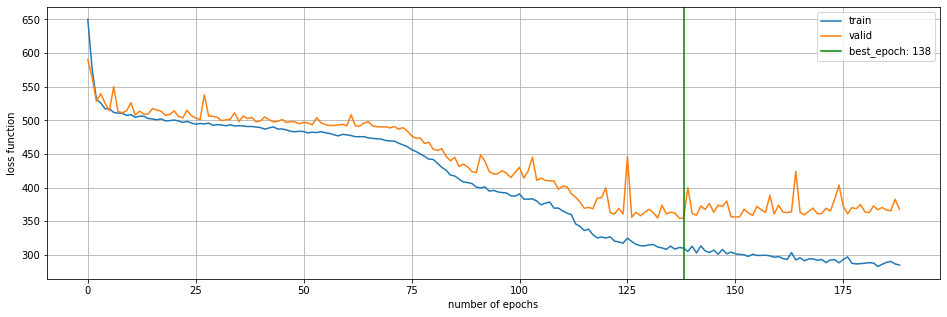

In [19]:
from utils.plot import plot_losses

plot_losses(train_loss_history, valid_loss_history, best_valid_score)

# simple feed forward model with embeddings
Source: https://yashuseth.blog/2018/07/22/pytorch-neural-network-for-tabular-data-with-categorical-embeddings/

In [31]:
# Hyper-parameters 
cat_vars = [
    "variable_1",
    "variable_4",
    "variable_6",
]
num_vars = [
    "variable_2",
    "variable_3",
    "variable_5",
    "variable_7",
    "variable_8",
]

hidden_size_layer_1 = 512
hidden_size_layer_2 = 256
hidden_size_layer_3 = 128
hidden_size_layer_4 = 64
lin_layer_sizes = [
    hidden_size_layer_1,
    hidden_size_layer_2,
    hidden_size_layer_3,
    hidden_size_layer_4,
]

num_epochs = 1_000
n_epochs_stop = 50
batch_size = 512
learning_rate = 0.001

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class FeedForwardNN(nn.Module):
    def __init__(
        self, 
        emb_dims, 
        no_of_cont, 
        lin_layer_sizes,
        output_size, 
        emb_dropout, 
        lin_layer_dropouts,
    ):
        """
        Parameters
        ----------

        emb_dims: List of two element tuples
          This list will contain a two element tuple for each
          categorical feature. The first element of a tuple will
          denote the number of unique values of the categorical
          feature. The second element will denote the embedding
          dimension to be used for that feature.

        no_of_cont: Integer
          The number of continuous features in the data.

        lin_layer_sizes: List of integers.
          The size of each linear layer. The length will be equal
          to the total number
          of linear layers in the network.

        output_size: Integer
          The size of the final output.

        emb_dropout: Float
          The dropout to be used after the embedding layers.

        lin_layer_dropouts: List of floats
          The dropouts to be used after each linear layer.
        """
        super(FeedForwardNN, self).__init__()

        # Embedding layers
        self.emb_layers = nn.ModuleList([nn.Embedding(x, y) for x, y in emb_dims])

        no_of_embs = sum([y for x, y in emb_dims])
        self.no_of_embs = no_of_embs
        self.no_of_cont = no_of_cont

        # Linear Layers
        first_lin_layer = nn.Linear(
            self.no_of_embs + self.no_of_cont,
            lin_layer_sizes[0],
        )

        self.lin_layers = nn.ModuleList(
            [first_lin_layer] + [nn.Linear(lin_layer_sizes[i], lin_layer_sizes[i + 1])
            for i in range(len(lin_layer_sizes) - 1)]
        )

        for lin_layer in self.lin_layers:
            nn.init.kaiming_normal_(lin_layer.weight.data)

        # Output Layer
        self.output_layer = nn.Linear(lin_layer_sizes[-1], output_size)
        nn.init.kaiming_normal_(self.output_layer.weight.data)

        # Batch Norm Layers
        self.first_bn_layer = nn.BatchNorm1d(self.no_of_cont)
        self.bn_layers = nn.ModuleList([nn.BatchNorm1d(size) for size in lin_layer_sizes])

        # Dropout Layers
        self.emb_dropout_layer = nn.Dropout(emb_dropout)
        self.droput_layers = nn.ModuleList([nn.Dropout(size) for size in lin_layer_dropouts])

    def forward(self, cat_data, cont_data):
        if self.no_of_embs != 0:
            x = [emb_layer(cat_data[:, i]) for i, emb_layer in enumerate(self.emb_layers)]
            x = torch.cat(x, 1)
            x = self.emb_dropout_layer(x)

        if self.no_of_cont != 0:
            normalized_cont_data = self.first_bn_layer(cont_data)

            if self.no_of_embs != 0:
                x = torch.cat([x, normalized_cont_data], 1) 
            else:
                x = normalized_cont_data

        for lin_layer, dropout_layer, bn_layer in zip(self.lin_layers, self.droput_layers, self.bn_layers):
            x = F.relu(lin_layer(x))
            x = bn_layer(x)
            x = dropout_layer(x)

        output = self.output_layer(x)

        return output

In [33]:
def return_dataset_and_loader_with_cat_num_split(
    df: pd.DataFrame, 
    cat_vars: list,
    num_vars: list,
    *, 
    target_name: str, 
    batch_size: int = 32, 
    shuffle: bool = True,
):
    dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(df[cat_vars].values.astype(np.int32)).type(torch.LongTensor),
        torch.from_numpy(df[num_vars].values.astype(np.float32)),
        torch.from_numpy(df[target_name].values.astype(np.float32)),
    )

    loader = torch.utils.data.DataLoader(
        dataset=dataset, 
        batch_size=batch_size, 
        shuffle=shuffle,
    )
    
    return dataset, loader

train_dataset, train_loader = return_dataset_and_loader_with_cat_num_split(
    df_train, cat_vars, num_vars, target_name="target", batch_size=batch_size, shuffle=True
)
test_dataset, test_loader = return_dataset_and_loader_with_cat_num_split(
    df_test, cat_vars, num_vars, target_name="target", batch_size=len(df_test), shuffle=False
)

In [34]:
cat_dims = [int(df_train[col].nunique()) for col in cat_vars]
cat_dims

[30, 5, 200]

In [35]:
emb_dims = [(x, min(50, (x + 1) // 2)) for x in cat_dims]
emb_dims

[(30, 15), (5, 3), (200, 50)]

In [37]:
model = FeedForwardNN(
    emb_dims, 
    no_of_cont=len(num_vars), 
    lin_layer_sizes=lin_layer_sizes,
    output_size=1, 
    emb_dropout=0.04,
    lin_layer_dropouts=[0.001, 0.01, 0.01, 0.01],
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [38]:
print(model)

FeedForwardNN(
  (emb_layers): ModuleList(
    (0): Embedding(30, 15)
    (1): Embedding(5, 3)
    (2): Embedding(200, 50)
  )
  (lin_layers): ModuleList(
    (0): Linear(in_features=73, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
  (first_bn_layer): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_layers): ModuleList(
    (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (emb_dropout_layer): Dropout(p=0.04,

In [39]:
def train_model_embeddings(
    model, 
    criterion, 
    optimizer, 
    train_loader: torch.utils.data.dataloader.DataLoader, 
    valid_loader: torch.utils.data.dataloader.DataLoader, 
    num_epochs: int, 
    n_epochs_stop: int,
    model_save_path: str,
    
):
    start_time = time.time()

    train_loss_history, valid_loss_history = [], []
    epochs_no_improve = 0
    best_valid_score = np.inf
    
    for epoch in range(1, num_epochs + 1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 30)
        
        # train
        model.train()
        running_train_loss = 0
        for idx, (cat_features, num_features, targets) in enumerate(train_loader):
            cat_features = cat_features.to(device)
            num_features = num_features.to(device)
            targets = targets.to(device)
            output = model(cat_features, num_features).reshape(-1)
            loss = criterion(output, targets)
            running_train_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        train_loss = running_train_loss / len(train_loader)
        train_loss_history.append(train_loss)
        
        # valid
        with torch.no_grad():
            model.eval()
            running_valid_loss = 0
            for idx, (cat_features, num_features, targets) in enumerate(valid_loader):
                cat_features = cat_features.to(device)
                num_features = num_features.to(device)
                targets = targets.to(device)
                output = model(cat_features, num_features).reshape(-1)
                loss = criterion(output, targets)
                running_valid_loss += loss.item()
        
        valid_loss = running_valid_loss / len(valid_loader)
        valid_loss_history.append(valid_loss)
        
        # save model 
        if valid_loss < best_valid_score:
            epochs_no_improve = 0
            perc_improvement = abs(((best_valid_score - valid_loss) / best_valid_score) * 100)
            print(
                f'valid_loss improved from {best_valid_score:.4f} to {valid_loss:.4f},'
                f' improvement: {perc_improvement:.2f}%'
            )
            best_valid_score = valid_loss

            torch.save(model.state_dict(), model_save_path)
        else:
            epochs_no_improve += 1
            print(f'No improvement in valid_loss for {epochs_no_improve} epochs!')
              
        print(
            f'train_loss : {train_loss}\n'
            f'valid_loss: {valid_loss}\n'
            f'{"-" * 30}' 
        )
        
        if epoch > 5 and epochs_no_improve == n_epochs_stop:
            print(f'Early stopping triggered after {epoch} epochs!')
            break
    
    print(f"Training lasted: {time.time() - start_time:.2f} seconds")
    
    return model, train_loss_history, valid_loss_history, best_valid_score

model, train_loss_history, valid_loss_history, best_valid_score = train_model_embeddings(
    model,
    criterion,
    optimizer,
    train_loader,
    test_loader,
    num_epochs,
    n_epochs_stop,
    '../models/embedding_model.pth'
)

Epoch 1/1000
------------------------------
valid_loss improved from inf to 144.5267, improvement: nan%
train_loss : 406.2748001433991
valid_loss: 144.52670288085938
------------------------------
Epoch 2/1000
------------------------------
valid_loss improved from 144.5267 to 28.4903, improvement: 80.29%
train_loss : 83.70176956679795
valid_loss: 28.490283966064453
------------------------------
Epoch 3/1000
------------------------------
valid_loss improved from 28.4903 to 9.2631, improvement: 67.49%
train_loss : 29.858615293607606
valid_loss: 9.263050079345703
------------------------------
Epoch 4/1000
------------------------------
valid_loss improved from 9.2631 to 3.7586, improvement: 59.42%
train_loss : 18.966110612009906
valid_loss: 3.7585558891296387
------------------------------
Epoch 5/1000
------------------------------
valid_loss improved from 3.7586 to 3.0685, improvement: 18.36%
train_loss : 16.157118592943466
valid_loss: 3.06850266456604
------------------------------

valid_loss improved from 0.6057 to 0.4672, improvement: 22.85%
train_loss : 3.7244830341129513
valid_loss: 0.467247873544693
------------------------------
Epoch 46/1000
------------------------------
No improvement in valid_loss for 1 epochs!
train_loss : 4.090420229094369
valid_loss: 1.0688270330429077
------------------------------
Epoch 47/1000
------------------------------
No improvement in valid_loss for 2 epochs!
train_loss : 4.228479574014853
valid_loss: 1.1720412969589233
------------------------------
Epoch 48/1000
------------------------------
No improvement in valid_loss for 3 epochs!
train_loss : 3.7738275475554413
valid_loss: 1.5540688037872314
------------------------------
Epoch 49/1000
------------------------------
No improvement in valid_loss for 4 epochs!
train_loss : 3.6969629473738617
valid_loss: 0.6133891344070435
------------------------------
Epoch 50/1000
------------------------------
No improvement in valid_loss for 5 epochs!
train_loss : 3.692124053017123

KeyboardInterrupt: 

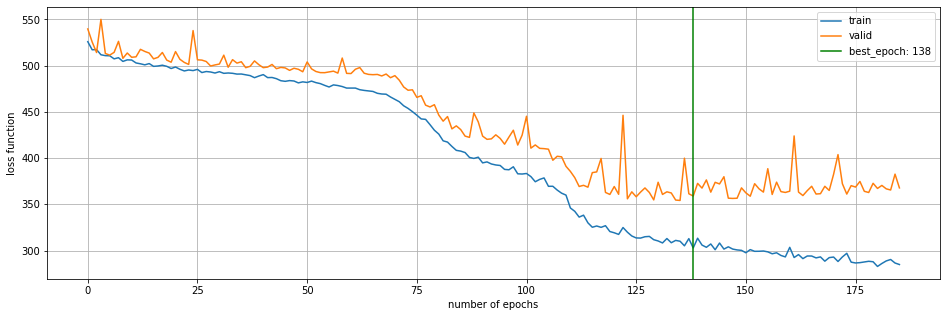

In [40]:
plot_losses(train_loss_history, valid_loss_history, best_valid_score, burn_in=3)

In [41]:
def calculate_loss(model, data_loader, device, criterion):
    with torch.no_grad():
        model.eval()
        running_loss = 0
        
        for data_tuple in data_loader:
            features = [data_tuple[i].to(device) for i in range(len(data_tuple)-1)]
            targets = data_tuple[-1].to(device)
            output = model(*features).reshape(-1)
            loss = criterion(output, targets)
            running_loss += loss.item()
        
        loss = running_loss / len(data_loader)

    print(f"{criterion}: {loss:.4f}")
        
    return loss

In [42]:
len(train_loader.dataset)

92853

In [43]:
len(train_loader), len(test_loader)

(182, 1)

In [44]:
criterion = nn.MSELoss()

calculate_loss(model, train_loader, device, criterion)
calculate_loss(model, test_loader, device, criterion)

MSELoss(): 0.4633
MSELoss(): 0.4757


0.47572433948516846

In [45]:
def add_predictions_to_df(df_test, test_loader):
    assert isinstance(test_loader.sampler, torch.utils.data.sampler.SequentialSampler)
    assert len(df_test) == test_loader.batch_size
    
    with torch.no_grad():
        model.eval()
        
        for data_tuple in test_loader:
            features = [data_tuple[i].to(device) for i in range(len(data_tuple)-1)]
            targets = data_tuple[-1].to(device)
            output = model(*features).reshape(-1)
            pred = output.detach().numpy()
    
    df_test["prediction"] = pred
    
    return df_test

In [46]:
df_test = add_predictions_to_df(df_test, test_loader)

/Users/giovanniganzinotti/.pyenv/versions/3.7.3/envs/pytorch-azure/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [47]:
mean_squared_error(df_test["target"], df_test["prediction"])

0.4757243322022243

In [ ]:
%%javascript
IPython.notebook.save_notebook()
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

In [ ]:
!jupyter nbconvert --to html $nb_name